In [1]:
import os
import numpy as np
import pandas as pd

In [84]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
import re

In [3]:
import matplotlib.pyplot as plt

In [4]:
import json

In [5]:
from sklearn.preprocessing import LabelEncoder

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
from imblearn.over_sampling import SMOTE

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [10]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [35]:
from nltk.corpus import stopwords
stopwords=stopwords.words("english")

In [39]:
from nltk.stem import PorterStemmer

In [11]:
df=pd.read_json("crawler-tid/tweets_json",lines=True)

In [12]:
df=df[['id','text']]

In [14]:
df.shape

(3930, 26)

In [15]:
df_atnt=pd.read_csv("chdata/att")
df_verizon=pd.read_csv("chdata/verizon")
df_t=pd.read_csv("chdata/t-mobile")

In [17]:
df_label=pd.concat([df_atnt,df_verizon,df_t],axis=0)

In [18]:
df_label.columns

Index(['_unit_id', '_golden', '_canary', '_unit_state', '_trusted_judgments',
       '_last_judgment_at', 'choose_one', 'choose_one:confidence', 'brand',
       'choose_one_gold', 'date', 'tid', 'uid'],
      dtype='object')

In [20]:
df_label=df_label[['brand','tid','choose_one','choose_one:confidence']]

In [21]:
df_label.columns=['brand','id','choose_one',"choose_one:confidence"]

In [22]:
np.unique(df_label['choose_one'])

array(['Churny', 'Non-churny'], dtype=object)

In [23]:
df_label=df_label.reindex()

In [24]:
mainDF=pd.merge(df,df_label,on="id")

In [26]:
mainDF.columns

Index(['contributors', 'coordinates', 'created_at', 'entities',
       'favorite_count', 'favorited', 'geo', 'id', 'id_str',
       'in_reply_to_screen_name', 'in_reply_to_status_id',
       'in_reply_to_status_id_str', 'in_reply_to_user_id',
       'in_reply_to_user_id_str', 'is_quote_status', 'lang', 'place',
       'possibly_sensitive', 'possibly_sensitive_appealable', 'retweet_count',
       'retweeted', 'source', 'text', 'truncated', 'user',
       'withheld_in_countries', 'brand', 'choose_one',
       'choose_one:confidence'],
      dtype='object')

In [27]:
mainDF=mainDF[['id','text','brand','choose_one']]

In [28]:
brands=np.unique(mainDF['brand'])

In [23]:
mainDF[(mainDF['brand']=="verizon") & (mainDF['choose_one']=="Churny")].shape

(404, 5)

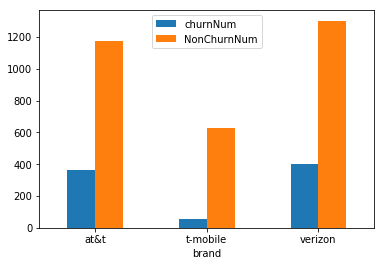

In [30]:
brandInfo={}
brandInfo['brand']=[]
brandInfo['churnNum']=[]
brandInfo['NonChurnNum']=[]
for brand in brands:
    brandInfo['brand'].append(brand)
    brandInfo['churnNum'].append(mainDF[(mainDF['brand']==brand) & (mainDF['choose_one']=="Churny")].shape[0])
    brandInfo['NonChurnNum'].append(mainDF[(mainDF['brand']==brand) & (mainDF['choose_one']=="Non-churny")].shape[0])
x=pd.DataFrame(brandInfo)
x=x.set_index("brand")
x.plot.bar(rot=0)

In [31]:
mainDF=mainDF.dropna()

# Preprocessing

In [43]:
porter=PorterStemmer()
def preprocessing(a_tweet):
    cleanTweet=[]
    a_tweet=a_tweet.split(" ")
    for word in a_tweet:
        word=word.strip()
        valid=re.search(pattern=r"[^A-Za-z]",string=word)==None
        if(word!="" and valid==True and word not in stopwords):
            word=porter.stem(word)
            cleanTweet.append(word)
    return " ".join(cleanTweet)

In [44]:
print(mainDF['text'][0])
preprocessing(mainDF['text'][0])

@barntiques859 every1 gone the Mangy Cat got go Verizon drop off cable box &amp; remote + GameStop exchange game rack which had no screws


'gone mangi cat got go verizon drop cabl box remot gamestop exchang game rack screw'

In [45]:
mainDF['text']=mainDF['text'].apply(preprocessing)

In [46]:
mainDF=mainDF.dropna()

In [48]:
mainDF.shape

(3930, 4)

In [49]:
mainDF.brand.value_counts()

verizon     1707
at&t        1540
t-mobile     683
Name: brand, dtype: int64

## Feature Selection

In [50]:
mainDF['label']=LabelEncoder().fit_transform(mainDF['choose_one'])
mainDF['brand']=LabelEncoder().fit_transform(mainDF['brand'])

In [51]:
mainDF.columns

Index(['id', 'text', 'brand', 'choose_one', 'label'], dtype='object')

In [54]:
mainDF=mainDF[['text','brand','label']]

In [55]:
vectorizer=TfidfVectorizer(stop_words="english")

In [56]:
X=vectorizer.fit_transform(mainDF['text'])

## Splitting Data

In [57]:
mainDF['label'].values

array([1, 1, 1, ..., 1, 1, 0])

In [58]:
X_train,X_test,y_train,y_test=train_test_split(X,mainDF['label'].values,stratify=mainDF.label.values)

## Doing Logistic Regression

In [59]:
LogReg=LogisticRegression()
LogReg.fit(X_train,y_train)

/home/silverstar/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [60]:
y_pred=LogReg.predict(X_test)

In [61]:
print(classification_report(y_test,y_pred,target_names=['class 0','class 1']))

              precision    recall  f1-score   support

     class 0       0.78      0.22      0.34       207
     class 1       0.82      0.98      0.90       776

   micro avg       0.82      0.82      0.82       983
   macro avg       0.80      0.60      0.62       983
weighted avg       0.81      0.82      0.78       983



In [62]:
confusion_matrix(y_test,y_pred)

array([[ 45, 162],
       [ 13, 763]])

In [81]:
RanFor=RandomForestClassifier(class_weight={0:45,1:1})
RanFor.fit(X_train,y_train)
y_pred=RanFor.predict(X_test)
print(classification_report(y_test,y_pred,target_names=['class 0','class 1']))
print(confusion_matrix(y_test,y_pred))
print("Accuracy="+str(np.mean(y_test==y_pred)))

/home/silverstar/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


              precision    recall  f1-score   support

     class 0       0.43      0.49      0.46       207
     class 1       0.86      0.83      0.84       776

   micro avg       0.76      0.76      0.76       983
   macro avg       0.64      0.66      0.65       983
weighted avg       0.77      0.76      0.76       983

[[102 105]
 [135 641]]
Accuracy=0.7558494404883012


In [70]:
svcModel=SVC(class_weight="balanced")
svcModel.fit(X_train,y_train)
y_pred=RanFor.predict(X_test)
print(classification_report(y_test,y_pred,target_names=['class 0','class 1']))
print(confusion_matrix(y_test,y_pred))
print("Accuracy="+str(np.mean(y_test==y_pred)))

/home/silverstar/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


              precision    recall  f1-score   support

     class 0       0.45      0.51      0.48       207
     class 1       0.86      0.83      0.85       776

   micro avg       0.76      0.76      0.76       983
   macro avg       0.65      0.67      0.66       983
weighted avg       0.78      0.76      0.77       983

[[106 101]
 [132 644]]
Accuracy=0.762970498474059
